# GP Regression Combine Kernels
- [A Visual Exploration of Gaussian Processes](https://distill.pub/2019/visual-exploration-gaussian-processes/)
- [Kernel Cookbook](https://www.cs.toronto.edu/~duvenaud/cookbook/)
- [Gaussian Process Kernels](https://peterroelants.github.io/posts/gaussian-process-kernels/)

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano.tensor as tt

import matplotlib.pyplot as plt
# Configure plot defaults
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['grid.color'] = '#666666'
%config InlineBackend.figure_format = 'png'

In [2]:
import warnings

# mute future warnings from theano
warnings.simplefilter(action="ignore", category=FutureWarning)

In [3]:
# set the seed
np.random.seed(1)

## Create Sinusoid with increasing amplitude

In [4]:
def amplitude(x):
    return x[..., 0]

def variable_sinusoid(x, A):
    return A*np.sin(3 * np.pi * x[..., 0])

# include trend

def generate_1d_data(num_training_points, observation_noise_variance):
    """
      Generate noisy sinusoidal observations at a random set of points.

      Returns:
         observation_index_points, observations
    """
    index_points_ = np.random.uniform(0., 10., (num_training_points, 1))
    index_points_ = index_points_.astype(np.float64)
    # y = f(x) + noise
    observations_ = ( variable_sinusoid(index_points_, amplitude(index_points_)) +
                   np.random.normal(loc=0,
                                    scale=np.sqrt(observation_noise_variance),
                                    size=(num_training_points)))
    return index_points_, observations_

In [5]:
# Generate training data with a known noise level (we'll later try to recover
# this value from the data).
NUM_TRAINING_POINTS = 100
observation_index_points_, observations_ = generate_1d_data(
    num_training_points=NUM_TRAINING_POINTS,
    observation_noise_variance=0.1)

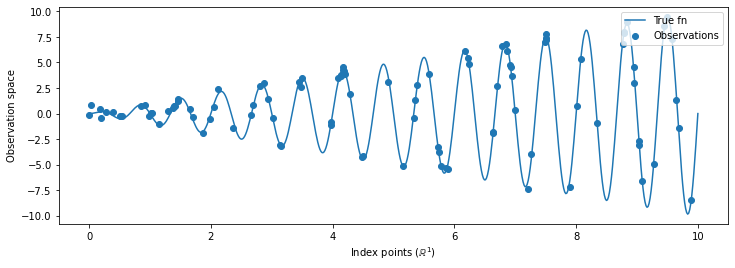

In [6]:
# new values from x=0 to x=20
X = np.linspace(0, 10, 600)[:,None]

# Plot the true function and observations.
plt.figure(figsize=(12, 4))
plt.plot(X, variable_sinusoid(X , amplitude(X)),
         label='True fn')
plt.scatter(observation_index_points_[:, 0], observations_,
            label='Observations')
leg = plt.legend(loc='upper right')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel(r"Index points ($\mathbb{R}^1$)")
plt.ylabel("Observation space")
plt.show()

## Coding the model in PyMC3
- [Marginal Likelihood Implementation](https://docs.pymc.io/notebooks/GP-Marginal.html)

**Note:** RBF kernel cannot predict the increasing amplitude as we move away from the origin. **reason** As the RBF kernel is stationary it will always return to $\mu=0$ in regions further away from observed training data.

**Linear times Periodic:** A linear kernel times a periodic results in functions which are periodic with increasing amplitude as we move away from the origin.

In [7]:
with pm.Model() as model:
    η_per = pm.HalfCauchy("η_per", beta=2, testval=1.0)
    period  = pm.Normal("period", mu=0.66, sigma=0.05)
    ℓ_psmooth = pm.Gamma("ℓ_psmooth", alpha=4, beta=3)
    c = pm.Lognormal("c", mu=0., sigma=2.0)
    cov = η_per**2 * pm.gp.cov.Periodic(1, period, ℓ_psmooth) * pm.gp.cov.Linear(1, c)

    # Specify the GP.  The default mean function is `Zero`.
    gp = pm.gp.Marginal(cov_func=cov)
    
    # The scale of the white noise term can be provided,
    sigma = pm.HalfCauchy("sigma", beta=5)
    y_ = gp.marginal_likelihood("y", X=observation_index_points_, y=observations_, noise=sigma)

    mp = pm.find_MAP()

I have used the `Periodic` priors from [Example: CO2 at Manua Loa](https://docs.pymc.io/notebooks/GP-MaunaLoa.html)
> `ℓ_psmooth`: The smoothness of the periodic component. It controls how “sinusoidal” the periodicity is. The plot of the data shows that seasonality is not an exact sine wave, but its not terribly different from one. We use a Gamma whose mode is at one, and doesn’t have too large of a variance, with most of the prior mass from around 0.5 and 2.
>
> `period`: The period. We put a very strong prior on 𝑝, the period that is centered at one. R+W fix 𝑝=1, since the period is annual.

In [13]:
import pandas as pd
pd.DataFrame({"Parameter": ["η_per", "period", "ℓ_psmooth", "c", "sigma"],
               "Value at MAP": [float(mp["η_per"]), float(mp["period"]), float(mp["ℓ_psmooth"]), float(mp["c"]), float(mp["sigma"])],
              "True value": [None, 2/3, None, 0.0, 0.1]})

,Parameter,Value at MAP,True value
0,η_per,1.397328,NaN
1,period,0.666553,0.666667
2,ℓ_psmooth,1.667928,NaN
3,c,0.074562,0.000000
4,sigma,0.286703,0.100000


### Use conditional distribution

In [9]:
# new values from x=0 to x=15
X_new = np.linspace(0, 15, 400)[:,None]

In [10]:
# add the GP conditional to the model, given the new X values
with model:
    f_pred = gp.conditional("f_pred", X_new)

# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with model:
    pred_samples = pm.sample_posterior_predictive([mp], vars=[f_pred], samples=1000)

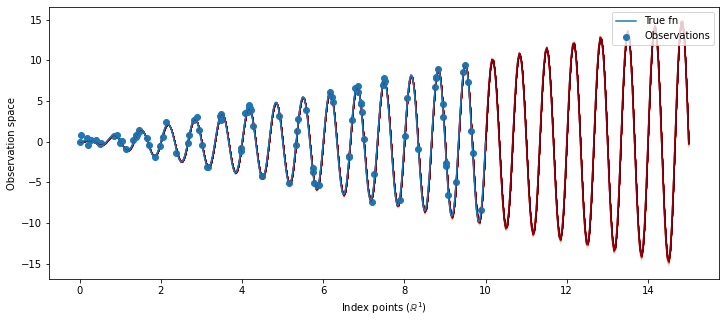

In [11]:
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, pred_samples["f_pred"], X_new)

# plot the data and the true latent function
plt.plot(X, variable_sinusoid(X , amplitude(X)),
         label='True fn')
ax.scatter(observation_index_points_[:, 0], observations_,
            label='Observations')

leg = plt.legend(loc='upper right')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.xlabel(r"Index points ($\mathbb{R}^1$)")
plt.ylabel("Observation space")
plt.show()